In [1]:
# Adds link to the scripts folder
import sys
import os
sys.path.append("../../scripts/")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from trajectory import Trajectory, create_trajectory_list, create_all_patient_trajectories
from hivevo.patients import Patient
import filenames
import copy
from activity import get_average_activity

# Activity plots

## Functions

Format of the dictionnaries : trajectories[region][rev/non_rev/syn/non_syn]

In [30]:
def make_trajectory_dict(remove_one_point=False):
    regions = ["env"]
    trajectories = {}

    for region in regions:
        # Create the dictionary with the different regions
        tmp_trajectories = create_all_patient_trajectories(region)
        if remove_one_point:
            tmp_trajectories = [traj for traj in tmp_trajectories if traj.t[-1] != 0]
        trajectories[region] = tmp_trajectories

        # Split into sub dictionnaries (rev, non_rev and all)
        rev = [traj for traj in trajectories[region] if traj.reversion == True]
        non_rev = [traj for traj in trajectories[region] if traj.reversion == False]
        syn = [traj for traj in trajectories[region] if traj.synonymous == True]
        non_syn = [traj for traj in trajectories[region] if traj.synonymous == False]
        trajectories[region] = {"rev": rev, "non_rev": non_rev,
                                "syn": syn, "non_syn": non_syn, "all": trajectories[region]}
        
    return trajectories
    
    
def get_mean_in_time(trajectories, nb_bins=20, freq_range=[0.4, 0.6]):
    """
    Computes the mean frequency in time of a set of trajectories from the point they are seen in the freq_range window.
    Returns the middle of the time bins and the computed frequency mean.
    """
    # Create bins and select trajectories going through the freq_range
    time_bins = np.linspace(-680, 3000, nb_bins)
    trajectories = [traj for traj in trajectories if np.sum(np.logical_and(
        traj.frequencies >= freq_range[0], traj.frequencies < freq_range[1]), dtype=bool)]

    # Offset trajectories to set t=0 at the point they are seen in the freq_range and adds all the frequencies / times
    # to arrays for later computation of mean
    t_traj = np.array([])
    f_traj = np.array([])
    for traj in trajectories:
        idx = np.where(np.logical_and(traj.frequencies >=
                                      freq_range[0], traj.frequencies < freq_range[1]))[0][0]
        traj.t = traj.t - traj.t[idx]
        t_traj = np.concatenate((t_traj, traj.t))
        f_traj = np.concatenate((f_traj, traj.frequencies))

    # Binning of all the data in the time bins
    filtered_fixed = [traj for traj in trajectories if traj.fixation == "fixed"]
    filtered_lost = [traj for traj in trajectories if traj.fixation == "lost"]
    freqs, fixed, lost = [], [], []
    for ii in range(len(time_bins) - 1):
        freqs = freqs + [f_traj[np.logical_and(t_traj >= time_bins[ii], t_traj < time_bins[ii + 1])]]
        fixed = fixed + [len([traj for traj in filtered_fixed if traj.t[-1] < time_bins[ii]])]
        lost = lost + [len([traj for traj in filtered_lost if traj.t[-1] < time_bins[ii]])]

    # Computation of the mean in each bin, active trajectories contribute their current frequency,
    # fixed contribute 1 and lost contribute 0
    mean = []
    for ii in range(len(freqs)):
        mean = mean + [np.sum(freqs[ii]) + fixed[ii]]
        mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])

    nb_active = [len(freq) for freq in freqs]
    nb_dead = [fixed[ii] + lost[ii] for ii in range(len(fixed))]

    return 0.5 * (time_bins[1:] + time_bins[:-1]), mean, nb_active, nb_dead
    
    
    
def make_mean_in_time_dict(trajectories, freq_range=[0.01, 0.99]):
    regions = ["env"]
    means = {}
    times = []

    means[str(freq_range)] = {}
    for region in regions:
        means[str(freq_range)][region] = {}
        for key in trajectories[region].keys():
            times, means[str(freq_range)][region][key], _, _ = get_mean_in_time(trajectories[region][key], freq_range=freq_range)
    return times, means, freq_range


def plot_mean_in_time(times, means, freq_ranges, savefig=None):
    regions = ["env"]
    colors = ["r", "b", "g"]
    fontsize=16
    fontsize2 = 20

    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,10), sharex=True, sharey=True)
    for idx_row, split_type in enumerate([["rev", "non_rev"], ["syn", "non_syn"]]):
        for idx_col, region in enumerate(regions):
            for idx_colors,freq_range in enumerate(freq_ranges):
                axs[idx_row, idx_col].plot(times, means[str(freq_range)][region][split_type[0]], f'{colors[idx_colors]}-')
                axs[idx_row, idx_col].plot(times, means[str(freq_range)][region][split_type[1]], f'{colors[idx_colors]}--')
                axs[idx_row, idx_col].grid()
                axs[idx_row, idx_col].set_ylim([-0.03, 1.03])
                if idx_row == 1:
                    axs[idx_row,idx_col].set_xlabel("Time [days]", fontsize=fontsize)
                if idx_col == 0:
                    axs[idx_row,idx_col].set_ylabel("Frequency", fontsize=fontsize)
                    axs[idx_row,idx_col].text(-0.3, 0.45, split_type[0], transform=axs[idx_row,idx_col].transAxes, fontsize=fontsize2)
                if idx_row == 0:
                    axs[idx_row,idx_col].text(0.45, 1.1, region, transform=axs[idx_row,idx_col].transAxes, fontsize=fontsize2)

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    if savefig is not None:
        plt.savefig(savefig, format="svg")

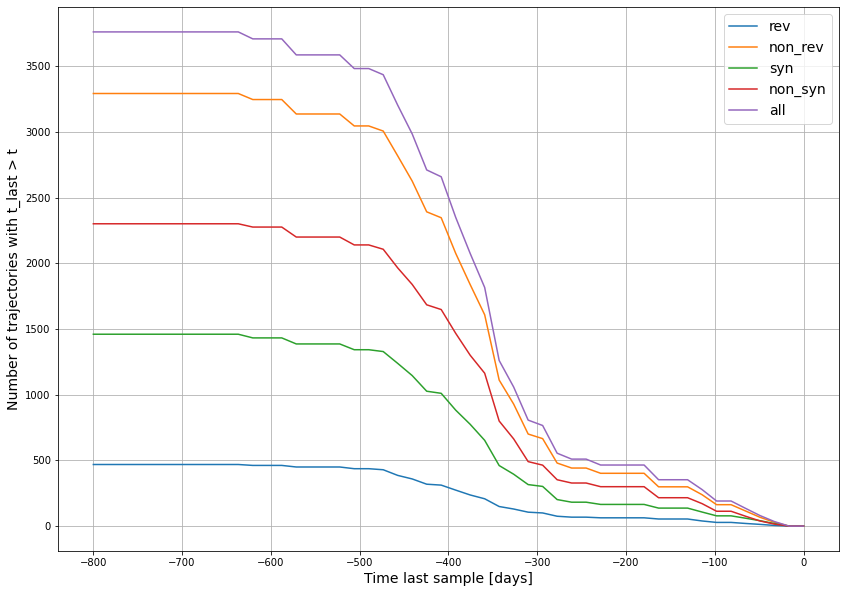

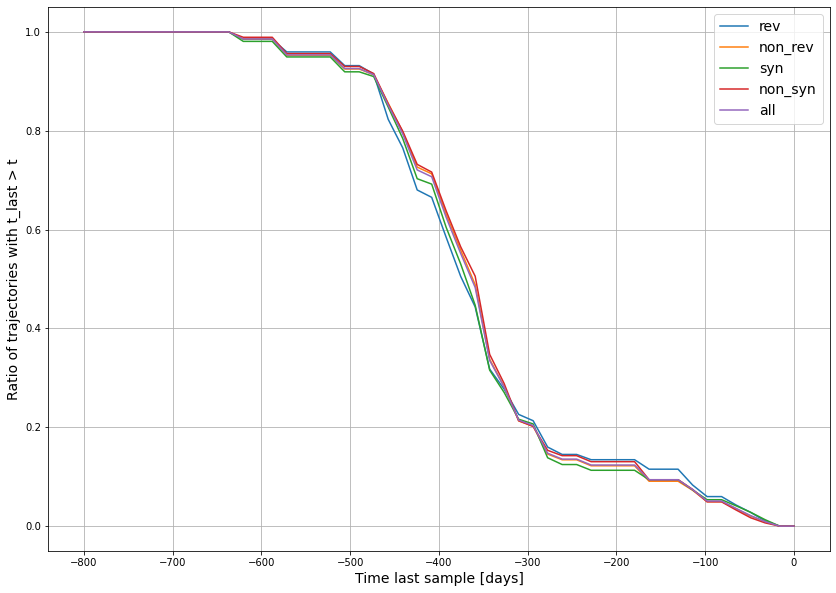

In [13]:
region = "env"
trajectories = make_trajectory_dict(remove_one_point=False)
times = np.linspace(-800, 0, 50)
number = {region:{}}

for mut_type in trajectories[region].keys():
    number[region][mut_type] = [len([traj for traj in trajectories[region][mut_type] if traj.t_previous_sample > times[idx]]) for idx in range(len(times))]

  
plt.figure(figsize=(14,10))
for mut_type in trajectories[region].keys():
    plt.plot(times, number[region][mut_type], label=mut_type)
plt.legend(fontsize=14)
plt.xlabel("Time last sample [days]", fontsize=14)
plt.ylabel('Number of trajectories with t_last > t', fontsize=14)
plt.grid()
plt.show()

plt.figure(figsize=(14,10))
for mut_type in trajectories[region].keys():
    plt.plot(times, np.array(number[region][mut_type])/number[region][mut_type][0], label=mut_type)
plt.legend(fontsize=14)
plt.xlabel("Time last sample [days]", fontsize=14)
plt.ylabel('Ratio of trajectories with t_last > t', fontsize=14)
plt.grid()
plt.show()

## Mean in time

In [49]:
region = "env"
freq_range = [0.2, 0.4]
trajectories = make_trajectory_dict(remove_one_point=False)
for mut_type in trajectories[region].keys():
    trajectories[region][mut_type] = [traj for traj in trajectories[region][mut_type] if traj.t_previous_sample > -400]
times, means, freq_range = make_mean_in_time_dict(trajectories, freq_range=freq_range)

<ipython-input-30-651ab1379460>:58: RuntimeWarning: invalid value encountered in double_scalars
  mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])


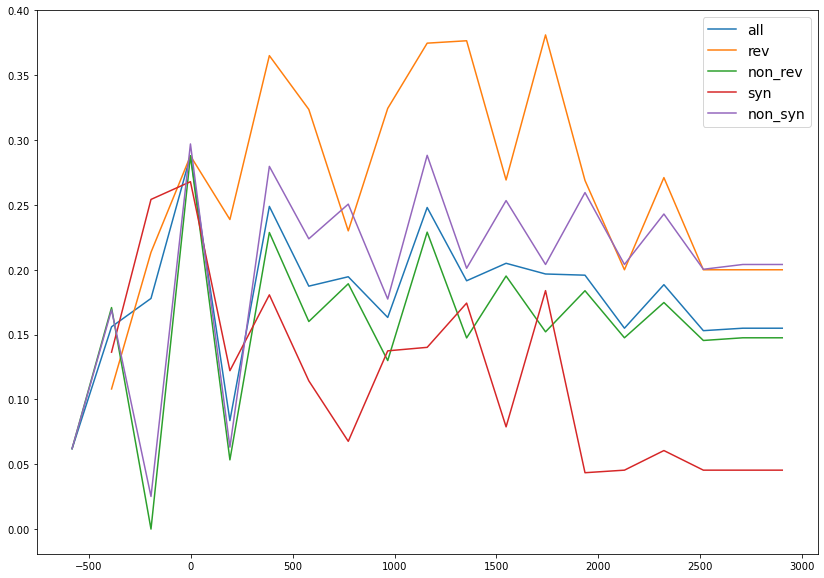

In [50]:
plt.figure(figsize=(14,10))
plt.plot(times, means[str(freq_range)]["env"]["all"], label="all")
plt.plot(times, means[str(freq_range)]["env"]["rev"], label="rev")
plt.plot(times, means[str(freq_range)]["env"]["non_rev"], label="non_rev")
plt.plot(times, means[str(freq_range)]["env"]["syn"], label="syn")
plt.plot(times, means[str(freq_range)]["env"]["non_syn"], label="non_syn")
plt.legend(fontsize=14)

plt.show()

In [51]:
region = "env"
freq_range = [0.2, 0.4]
trajectories = make_trajectory_dict(remove_one_point=False)
for mut_type in trajectories[region].keys():
    trajectories[region][mut_type] = [traj for traj in trajectories[region][mut_type] if traj.t_previous_sample > -500]
times, means, freq_range = make_mean_in_time_dict(trajectories, freq_range=freq_range)

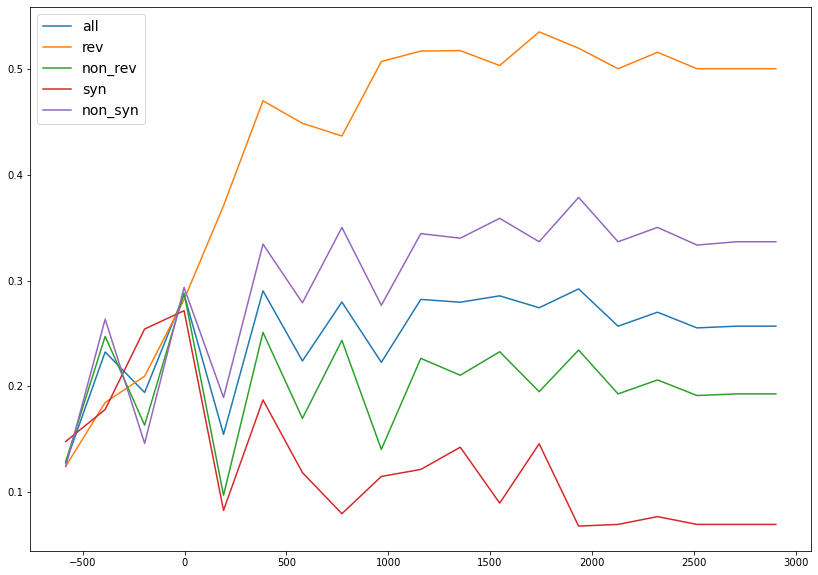

In [52]:
plt.figure(figsize=(14,10))
plt.plot(times, means[str(freq_range)]["env"]["all"], label="all")
plt.plot(times, means[str(freq_range)]["env"]["rev"], label="rev")
plt.plot(times, means[str(freq_range)]["env"]["non_rev"], label="non_rev")
plt.plot(times, means[str(freq_range)]["env"]["syn"], label="syn")
plt.plot(times, means[str(freq_range)]["env"]["non_syn"], label="non_syn")
plt.legend(fontsize=14)

plt.show()

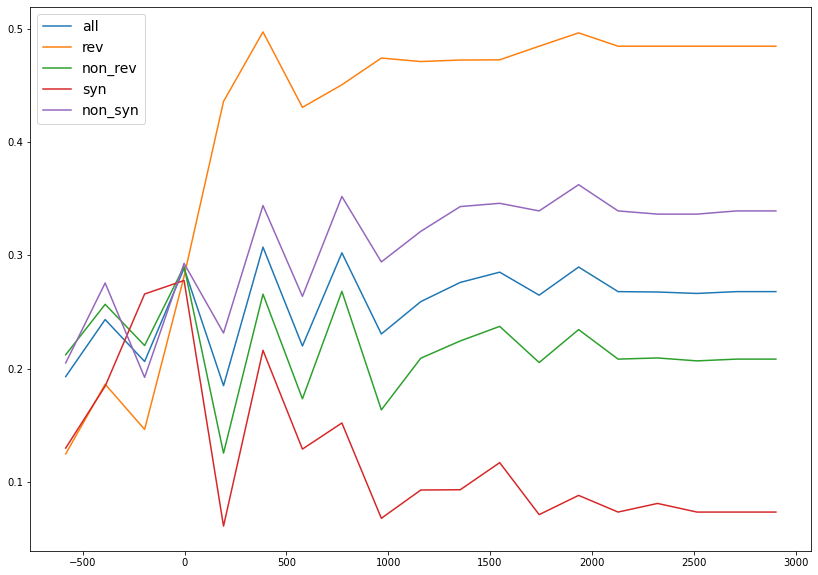

In [70]:
region = "env"
freq_range = [0.2, 0.4]
trajectories = make_trajectory_dict(remove_one_point=False)
for mut_type in trajectories[region].keys():
    trajectories[region][mut_type] = [traj for traj in trajectories[region][mut_type] if traj.t_previous_sample < -300]
times, means, freq_range = make_mean_in_time_dict(trajectories, freq_range=freq_range)

plt.figure(figsize=(14,10))
plt.plot(times, means[str(freq_range)]["env"]["all"], label="all")
plt.plot(times, means[str(freq_range)]["env"]["rev"], label="rev")
plt.plot(times, means[str(freq_range)]["env"]["non_rev"], label="non_rev")
plt.plot(times, means[str(freq_range)]["env"]["syn"], label="syn")
plt.plot(times, means[str(freq_range)]["env"]["non_syn"], label="non_syn")
plt.legend(fontsize=14)

plt.show()

<ipython-input-30-651ab1379460>:58: RuntimeWarning: invalid value encountered in double_scalars
  mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])


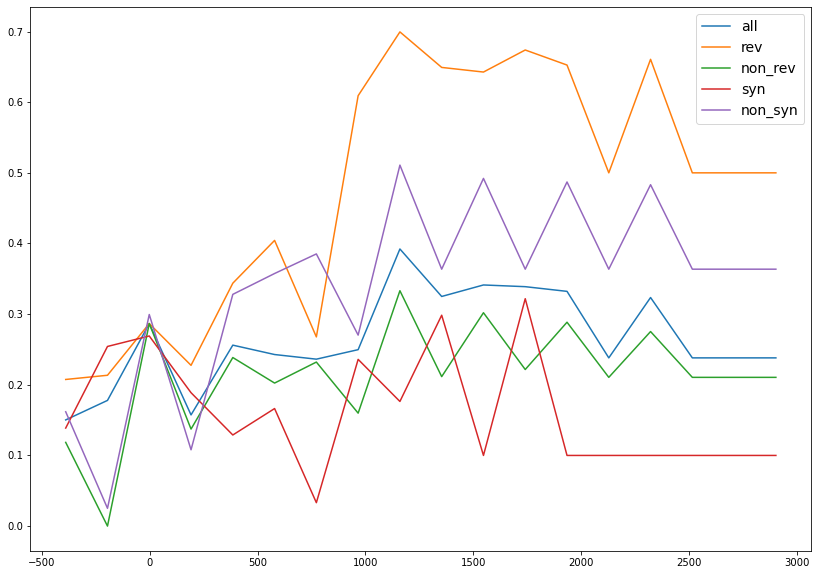

In [71]:
region = "env"
freq_range = [0.2, 0.4]
trajectories = make_trajectory_dict(remove_one_point=False)
for mut_type in trajectories[region].keys():
    trajectories[region][mut_type] = [traj for traj in trajectories[region][mut_type] if traj.t_previous_sample > -300]
times, means, freq_range = make_mean_in_time_dict(trajectories, freq_range=freq_range)

plt.figure(figsize=(14,10))
plt.plot(times, means[str(freq_range)]["env"]["all"], label="all")
plt.plot(times, means[str(freq_range)]["env"]["rev"], label="rev")
plt.plot(times, means[str(freq_range)]["env"]["non_rev"], label="non_rev")
plt.plot(times, means[str(freq_range)]["env"]["syn"], label="syn")
plt.plot(times, means[str(freq_range)]["env"]["non_syn"], label="non_syn")
plt.legend(fontsize=14)

plt.show()